# Geographically Weighted Hedonic Regression Model with mwgr for San Miguel

In [18]:
import os
import folium
import shapely
import descartes
import pygam
import random
import osmnx as ox
import networkx as nx
import scipy as scp
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ox.config(use_cache = True, log_console = False)

In [3]:
os.chdir("/home/chris/Dropbox/RS_Project/RSSTARTUP_repo/Product_Dev/immo_model")

base_path = os.getcwd()
figure_path = os.path.join(base_path, "Figures")
vector_path = os.path.join(base_path, "Vector")
raster_path = os.path.join(base_path, "Raster")

## Load vector data for San Miguel

/home/chris/miniconda3/envs/GHR_SM/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


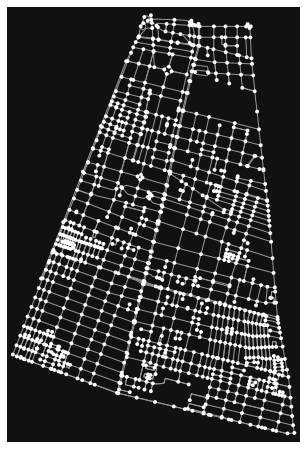

In [4]:
AOI_SMbbox = gpd.read_file("Vector/AOI_SM.geojson")
AOI_SMamyDF = gpd.read_file("Vector/AOI_SM_amyPoints.geojson")
AOI_SMlesDF = gpd.read_file("Vector/AOI_SM_lesPoints.geojson")
AOI_SMresDF = gpd.read_file("Vector/AOI_SM_resPoints.geojson")
BasePrice_SM = gpd.read_file("Vector/BasePrice_SM.geojson", crs = 9184)

# Load Street from OSM API
AOI = "San Miguel, Chile"
graph = ox.graph_from_place(AOI, network_type = "drive")
fig, ax = ox.plot_graph(graph)

In [5]:
assert AOI_SMamyDF.crs == AOI_SMbbox.crs

### Calculate distance for San Miguel

In [6]:
ox.save_graph_geopackage(graph, vector_path + "AOI_SM_Street.gpkg")
nodes, streets = ox.graph_to_gdfs(graph)

In [7]:
print(BasePrice_SM.valor_2)

0      72271.0
1      66796.0
2      63921.0
3      45990.0
4      77746.0
        ...   
61     34766.0
62     35142.0
63     63921.0
64    137697.0
65     48728.0
Name: valor_2, Length: 66, dtype: float64


<AxesSubplot:>

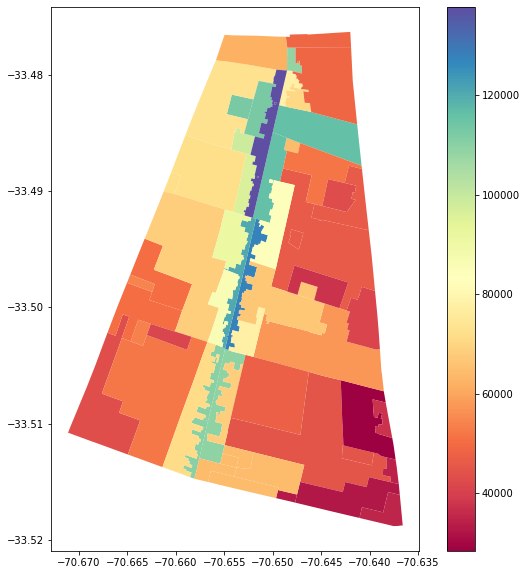

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
BasePrice_SM.plot(column = "valor_2", cmap = "Spectral",  ax = ax, legend = True)

SM_map = folium.Map([-33.495, -70.655], zoom_start = 13, tiles = "Stamen Terrain", 
                    crs = "EPSG:9184")

style = {"color": "#FFDD66", 
          "weight": "1"}

Street_json = streets.to_json

folium.GeoJson(Street_json, style_function = lambda x: style).add_to(SM_map)

SM_map

## Distance calculation point(amenities, leisure) to residence

In [9]:
# Get X Y coordinates for each residential, leisure, and amenities point
SM_resXY = [(x, y) for x, y in zip(AOI_SMresDF["geometry"].x, AOI_SMresDF["geometry"].y)]
SM_lesXY = [(x, y) for x, y in zip(AOI_SMlesDF["geometry"].x, AOI_SMlesDF["geometry"].y)]
SM_amyXY = [(x, y) for x, y in zip(AOI_SMamyDF["geometry"].x, AOI_SMamyDF["geometry"].y)]

In [23]:
nnodeRes_ls = []
nnodeLes_ls = []
nnodeAmy_ls = []

for i in SM_resXY:
    node = ox.distance.nearest_nodes(graph, i[0], i[1])
    nnodeRes_ls.append(node)
        
for i in SM_lesXY:
    node = ox.distance.nearest_nodes(graph, i[0], i[1])
    nnodeLes_ls.append(node)
    
for i in SM_amyXY:
    node = ox.distance.nearest_nodes(graph, i[0], i[1])
    nnodeAmy_ls.append(node)


AOI_SMresDF = AOI_SMresDF.assign(NNode = nnodeRes_ls)
AOI_SMlesDF = AOI_SMlesDF.assign(NNode = nnodeLes_ls)
SOI_SMamyDF = AOI_SMamyDF.assign(NNode = nnodeAmy_ls)


In [29]:
for point in AOI_SMresDF["geometry"]:
    for poly in BasePrice_SM["geometry"]
    print(poly)

POINT (-70.6514636 -33.4931727)
POINT (-70.6517958 -33.4931054)
POINT (-70.6517338 -33.4928925)
POINT (-70.6514972 -33.4929405)
POINT (-70.6514016 -33.4929598)
POINT (-70.6514636 -33.4931727)
POINT (-70.655345 -33.5054664)
POINT (-70.6551944 -33.5054965)
POINT (-70.6552901 -33.505844)
POINT (-70.6554425 -33.5058148)
POINT (-70.655345 -33.5054664)
POINT (-70.6562012 -33.5085116)
POINT (-70.6553394 -33.5086792)
POINT (-70.6553666 -33.5087765)
POINT (-70.6562284 -33.5086088)
POINT (-70.6562012 -33.5085116)
POINT (-70.6613578 -33.5182998)
POINT (-70.6612712 -33.5183187)
POINT (-70.6613232 -33.5184843)
POINT (-70.6614098 -33.5184654)
POINT (-70.6613578 -33.5182998)
POINT (-70.6643773 -33.516692)
POINT (-70.6643445 -33.5165744)
POINT (-70.6642741 -33.516588)
POINT (-70.6643068 -33.5167056)
POINT (-70.6643773 -33.516692)
POINT (-70.6674502 -33.518331)
POINT (-70.6674084 -33.5181909)
POINT (-70.6673376 -33.5182056)
POINT (-70.6673794 -33.5183456)
POINT (-70.6674502 -33.518331)
POINT (-70.66818

In [26]:
test_route = nx.shortest_path(graph, random.choice(AOI_SMresDF["NNode"]), random.choice(AOI_SMlesDF["NNode"]))

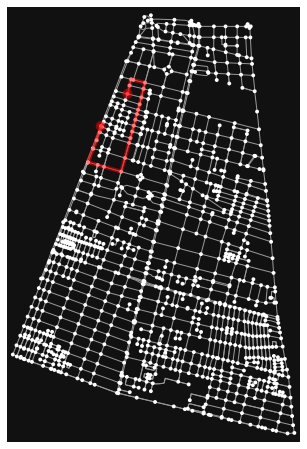

In [27]:
fig, ax = ox.plot_graph_route(graph, test_route)

<AxesSubplot:>

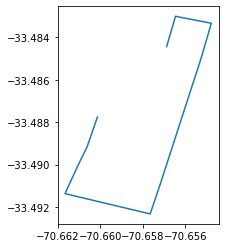

In [28]:
line = []

for j in test_route:
    pos = (graph.nodes[j]["x"], graph.nodes[j]["y"])
    line.append(pos)
    
LS = shapely.geometry.LineString(line)
gdf_troute = pd.DataFrame(data = [["test route", LS]], columns = ["test_route", "geometry"])
gdf_troute = gpd.GeoDataFrame(gdf_troute, geometry = "geometry")

gdf_troute.plot()

json_troute = gdf_troute.to_json()

SMtroute_map = folium.Map([-70.655, -33.495], zoom_start = 20, tiles = "Stamen Terrain", 
                    crs = "EPSG:9184")

style = {"color": "#FFDD66", 
          "weight": "1"}

route_style = {"color": "#FF0000", 
              "weight": "5"}

folium.GeoJson(Street_json, style_function = lambda x: style).add_to(SMtroute_map)
folium.GeoJson(json_troute, style_function = lambda x: route_style).add_to(SMtroute_map)

folium.Marker(SM_resXY[0], 
              popup = "Resident origin",
              icon = folium.Icon(color = "green", prefix = "fa", icon = "address-card")).add_to(SMtroute_map)

folium.Marker(SM_amyXY[-1], 
              popup = "Amenity destination",
              icon = folium.Icon(color = "red", prefix = "fa", icon = "star-o")).add_to(SMtroute_map)

SMtroute_map

### Calculate distance in batch loop

In [ ]:
SMroutes_resamy = []

for i in resNode_ls:
    for j in amyNode_ls:
        dist = nx.all_shortest_paths(graph, i, j)
        SMroutes_resamy.append(dist)

## PyGAM = Hedonic Regression